# Chapter 6 - Model-agnostic versus Model-specific Explainability

SHAP values show the impact of each feature for a given prediction and the overall model behavior in the decision-making process. This notebook provides a walkthrough of assessing explainability using **KernelSHAP**, a model-agnostic method implemented in the SHAP library. We will use the [Animal Shelter Analytics dataset](https://www.kaggle.com/datasets/jackdaoud/animal-shelter-analytics). A modified version of the dataset, animal_shelter.csv, is available at the book's GitHub repo. This notebook is tested with TensorFlow 2.10.1 and Python 3.9.10 using Amazon SageMaker Studio ml.m5.large general-purpose instance with 2 vCPU and 8 GiB. [Link](https://aws.amazon.com/sagemaker/pricing/) for instance pricing reference. Alternatively, you can try this on your preferred IDE.

## Install and load libraries

In [2]:
#install essential libraries

!pip install shap

In [3]:
# Load libraries

%matplotlib inline

import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import sklearn
import shap
import os
import re
import string
from platform import python_version
import warnings

warnings.filterwarnings("ignore")

os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

print(f'TensorFlow version: {tf.__version__}')
print(f'Python version: {python_version()}')

TensorFlow version: 2.11.0
Python version: 3.9.10


## Prepare the dataset

Load and explore the dataset with the following data schema:
- **Outcome Type** - State of pet at the time of recording the outcome. This is the target label to predict (0 = Transfer, 1 = Adoption)
- **Intake Type** - Circumstances bringing the pet to the center
- **Intake Condition** - Health condition of pet when entered the center
- **Animal Type** - Type of pet
- **Breed** - Breed of pet
- **Color** - Color of pet

In [4]:
# Load raw dataset

df = pd.read_csv('./animal_shelter.csv')
df.head(5)

,Intake Type,Intake Condition,Animal Type,Breed,Color,Outcome Type
0,Public Assist,Normal,Dog,Great Dane Mix,Black,Adoption
1,Stray,Normal,Dog,Pit Bull,Brown/White,Transfer
2,Stray,Normal,Dog,Chihuahua Shorthair,Tricolor,Transfer
3,Stray,Normal,Cat,Domestic Shorthair Mix,Brown Tabby,Adoption
4,Stray,Normal,Cat,Domestic Shorthair Mix,Black/White,Transfer


In [5]:
# Drop rows that contain missing values.

df.dropna()
df.isna().sum()

Intake Type         0
Intake Condition    0
Animal Type         0
Breed               0
Color               0
Outcome Type        0
dtype: int64

In [6]:
# Prepare text cleaning function

def preprocess_text(input_data):
    lowercase = tf.strings.lower(input_data)
    stripped_html = tf.strings.regex_replace(lowercase, "<br />", " ")
    return tf.strings.regex_replace(stripped_html, f"[{re.escape(string.punctuation)}]", "")

# Vectorize text features

from tensorflow.keras import layers

tf.keras.utils.set_random_seed(42)

max_features = 10000
sequence_length = 250

vectorize_layer = layers.TextVectorization(
    standardize=preprocess_text,
    max_tokens=max_features,
    output_mode="int",
    output_sequence_length=sequence_length,
)

vectorize_layer.adapt(df['Breed'])
vector_breed = vectorize_layer(df['Breed'])
vector_breed = vector_breed.numpy()
df['Breed'] = vector_breed

vectorize_layer.adapt(df['Color'])
vector_color = vectorize_layer(df['Color'])
vector_color = vector_color.numpy()
df['Color'] = vector_color

In [7]:
df.head(5)

,Intake Type,Intake Condition,Animal Type,Breed,Color,Outcome Type
0,Public Assist,Normal,Dog,28,5,Adoption
1,Stray,Normal,Dog,6,8,Transfer
2,Stray,Normal,Dog,9,17,Transfer
3,Stray,Normal,Cat,4,2,Adoption
4,Stray,Normal,Cat,4,3,Transfer


In [8]:
# For simplicity, filter rows with Adoption and Transfer target labels to create a new dataset

data = df.loc[df['Outcome Type'].isin(['Adoption','Transfer'])]
data.to_csv('modified_animal_shelter.csv', index=False)

In [9]:
# Read new dataset

new_df = pd.read_csv('modified_animal_shelter.csv')

# Convert target labels to numerical value

new_df['Outcome Type'].replace(('Adoption', 'Transfer'), (1, 0), inplace=True)
new_df.head(5)

,Intake Type,Intake Condition,Animal Type,Breed,Color,Outcome Type
0,Public Assist,Normal,Dog,28,5,1
1,Stray,Normal,Dog,6,8,0
2,Stray,Normal,Dog,9,17,0
3,Stray,Normal,Cat,4,2,1
4,Stray,Normal,Cat,4,3,0


In [10]:
# Use LabelEncoder to normalize and encode categorical columns to numerical values

from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(new_df['Intake Type'])
new_df['Intake Type'] = le.transform(new_df['Intake Type'])

le = preprocessing.LabelEncoder()
le.fit(new_df['Intake Condition'])
new_df['Intake Condition'] = le.transform(new_df['Intake Condition'])

le = preprocessing.LabelEncoder()
le.fit(new_df['Animal Type'])
new_df['Animal Type'] = le.transform(new_df['Animal Type'])


new_df.head(5)

,Intake Type,Intake Condition,Animal Type,Breed,Color,Outcome Type
0,3,5,2,28,5,1
1,4,5,2,6,8,0
2,4,5,2,9,17,0
3,4,5,1,4,2,1
4,4,5,1,4,3,0


<AxesSubplot: >

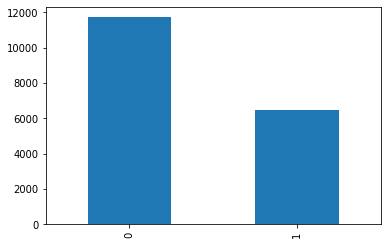

In [11]:
# Visualize frequency distribution
new_df['Outcome Type'].value_counts().plot(kind = 'bar')

In [12]:
new_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18180 entries, 0 to 18179
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Intake Type       18180 non-null  int64
 1   Intake Condition  18180 non-null  int64
 2   Animal Type       18180 non-null  int64
 3   Breed             18180 non-null  int64
 4   Color             18180 non-null  int64
 5   Outcome Type      18180 non-null  int64
dtypes: int64(6)
memory usage: 852.3 KB


In [13]:
# Assign model features to variables

import numpy as np
numerical_features = new_df.select_dtypes(include=np.number).columns.drop('Outcome Type')

X = new_df[numerical_features]
y = new_df['Outcome Type']

print(f'Model features: {X.columns.values}')
print(f'Model target: {y.name}')

Model features: ['Intake Type' 'Intake Condition' 'Animal Type' 'Breed' 'Color']
Model target: Outcome Type


In [14]:
# Sample a subset of dataset for shorter runtime

from sklearn.utils import resample

X, y = resample(X, y, n_samples=200, random_state=0)

In [15]:
# Split the data into 80% training and 20% testing

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state = 42)

print(f'X_train count: {X_train.shape[0]}')
print(f'y_train count: {y_train.shape[0]}')
print(f'X_test count: {X_test.shape[0]}')
print(f'y_test count: {y_test.shape[0]}')

X_train count: 160
y_train count: 160
X_test count: 40
y_test count: 40


## Train a Model

We are ready to build a simple neural network for predicting target Outcome Type.

In [16]:
# Build a simple model

model = tf.keras.Sequential([
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid') 
])

In [17]:
#Compile model

model.compile(
    loss = tf.keras.losses.binary_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate = 0.02),
    metrics = [
        tf.keras.metrics.BinaryAccuracy(name='accuracy'),
        tf.keras.metrics.Precision(name='precision'),
        tf.keras.metrics.Recall(name='recall')
    ]
)

m = model.fit(X_train, y_train, epochs=10)

Epoch 1/10
5/5 [==============================] - 1s 5ms/step - loss: 17.3718 - accuracy: 0.4938 - precision: 0.2973 - recall: 0.4314
Epoch 2/10
5/5 [==============================] - 0s 4ms/step - loss: 1.1641 - accuracy: 0.6313 - precision: 0.3182 - recall: 0.1373    
Epoch 3/10
5/5 [==============================] - 0s 4ms/step - loss: 0.9107 - accuracy: 0.6812 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 4/10
5/5 [==============================] - 0s 4ms/step - loss: 0.7526 - accuracy: 0.6313 - precision: 0.1000 - recall: 0.0196    
Epoch 5/10
5/5 [==============================] - 0s 3ms/step - loss: 0.6554 - accuracy: 0.6812 - precision: 0.0000e+00 - recall: 0.0000e+00
Epoch 6/10
5/5 [==============================] - 0s 3ms/step - loss: 0.6502 - accuracy: 0.6687 - precision: 0.2500 - recall: 0.0196    
Epoch 7/10
5/5 [==============================] - 0s 4ms/step - loss: 0.6282 - accuracy: 0.6812 - precision: 0.5000 - recall: 0.0392    
Epoch 8/10
5/5 [====================

## Explain a Model with SHAP

Compute and visualize Shapley values using different plots provided by SHAP.

In [18]:
# Instantiates KernelExplainer
e = shap.KernelExplainer(model, X_train)

# Subsamples a data set for efficiency
shap_values = e.shap_values(X_test)

print(f'SHAP values length: {len(shap_values)}')

Using 160 background data samples could cause slower run times. Consider using shap.sample(data, K) or shap.kmeans(data, K) to summarize the background as K samples.


  0%|          | 0/40 [00:00<?, ?it/s]

SHAP values length: 1


### Force Plot

The SHAP force plot shows which features influenced the model’s prediction for a single observation. Starting at the base value, we can see the increment or decrement of each feature leads us to the final prediction for this sample. Red means the feature pushes the prediction higher to the right, while blue push a lower value prediction to the left. 

In [19]:
shap.initjs()

# Explain a specific instance
shap.force_plot(e.expected_value, shap_values=shap_values[0][1,:], features=X_test.iloc[1,:])

We can also visualize the overall model behavior with aggregated SHAP values using force plot.

In [20]:
# Explain overall feature attribution
shap.force_plot(e.expected_value, shap_values[0], X_test)

### Decision Plot

We can aggregate and visualize SHAP values using a decision plot to understand the overall model behavior in decision-making. The features are ordered by descending importance, and the lines move upwards from the bottom at a base value to their final prediction. The X-axis represents SHAP values for each feature on the y-axis.

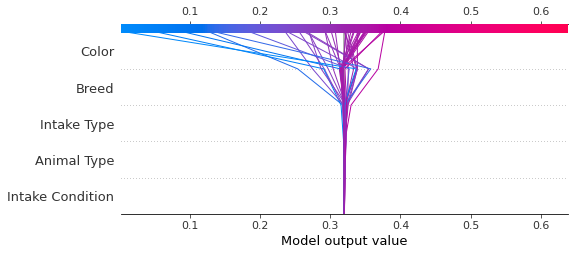

In [21]:
# Visualize a decision_plot

shap.decision_plot(e.expected_value, shap_values[0], X_test)

### Summary Bar Plot

The summary bar plot shows the mean absolute SHAP values for each feature across all observations, which is useful for analyzing the global effect of the features.

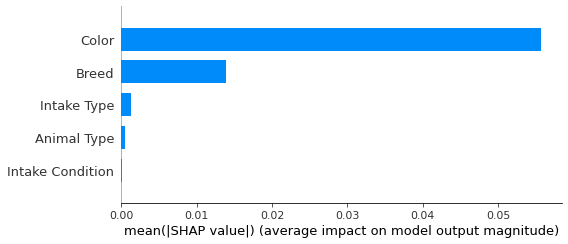

In [22]:
# Bar for multi-output
shap.summary_plot(shap_values[0], X_test, plot_type="bar")

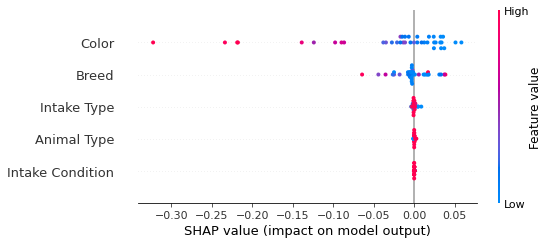

In [23]:
# Default dot for single output 
shap.summary_plot(shap_values[0], X_test)

### Dependence Plot

A dependence plot shows a single feature attribution on the model predictions. The second feature is chosen by default.

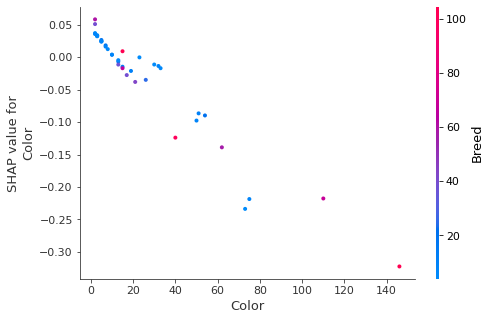

In [24]:
shap.dependence_plot(4, shap_values[0], X_test)

A vertical distinct color pattern shows an interaction effect between the two features.

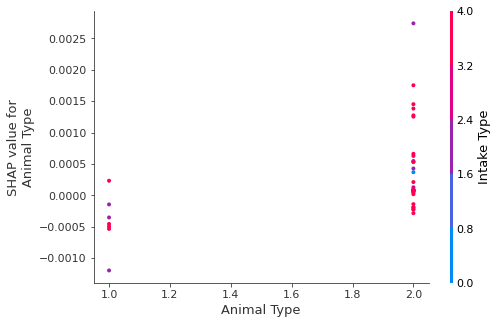

In [25]:
shap.dependence_plot('Animal Type', shap_values[0], X_test, interaction_index="Intake Type")

Calculating Shapley values with large datasets using Kernel SHAP can be time-consuming and computationally intensive. To improve the runtime and enhance scalability, Amazon SageMaker Clarify parallelizes SHAP computation. Refer to [Amazon SageMaker Clarify: Machine Learning Bias Detection and Explainability in the Cloud](https://assets.amazon.science/45/76/30bab4f14ccab96cfe8067ed2b4a/amazon-sagemaker-clarify-machine-learning-bias-detection-and-explainability-in-the-cloud.pdf) for more info on Amazon SageMaker Clarify and Kernel SHAP.